# Advanced ML: Домашнее задание 3

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from tqdm.notebook import tqdm
from scipy.sparse import csr_matrix, vstack

## Task 1

 Прочитайте и проанализируйте данные, выберите турниры, в которых есть данные
о составах команд и повопросных результатах (поле *mask* в results.pkl). Для
унификации предлагаю:
 - взять в тренировочный набор турниры с dateStart из 2019 года;
 - в тестовый — турниры с dateStart из 2020 года.

In [2]:
tournaments = pickle.load(open('data/tournaments.pkl', 'rb'))
results = pickle.load(open('data/results.pkl', 'rb'))
players = pickle.load(open('data/players.pkl', 'rb'))

In [3]:
tournaments_train = {key: value for key, value in tournaments.items() if value['dateStart'][:4] == '2019'}
tournaments_test = {key: value for key, value in tournaments.items() if value['dateStart'][:4] == '2020'}

In [4]:
print(f'Number of tournaments in the train set: {len(tournaments_train)}')
print(f'Number of tournaments in the test set: {len(tournaments_test)}')

Number of tournaments in the train set: 687
Number of tournaments in the test set: 418


In [5]:
print('Sample of the tournament object:')
tournaments_train[4772]

Sample of the tournament object:


{'id': 4772,
 'name': 'Синхрон северных стран. Зимний выпуск',
 'dateStart': '2019-01-05T19:00:00+03:00',
 'dateEnd': '2019-01-09T19:00:00+03:00',
 'type': {'id': 3, 'name': 'Синхрон'},
 'season': '/seasons/52',
 'orgcommittee': [{'id': 28379,
   'name': 'Константин',
   'patronymic': 'Владимирович',
   'surname': 'Сахаров'}],
 'synchData': {'dateRequestsAllowedTo': '2019-01-09T23:59:59+03:00',
  'resultFixesTo': '2019-01-19T23:59:59+03:00',
  'resultsRecapsTo': '2019-01-11T23:59:59+03:00',
  'allowAppealCancel': True,
  'allowNarratorErrorAppeal': False,
  'dateArchivedAt': '2019-01-26T23:59:59+03:00',
  'dateDownloadQuestionsFrom': '2019-01-04T00:00:00+03:00',
  'dateDownloadQuestionsTo': '2019-01-09T19:00:00+03:00',
  'hideQuestionsTo': '2019-01-09T23:59:59+03:00',
  'hideResultsTo': '2019-01-09T23:59:59+03:00',
  'allVerdictsDone': None,
  'instantControversial': True},
 'questionQty': {'1': 12, '2': 12, '3': 12}}

In [6]:
print('Sample of the results object:')
print(f'Number of teams: {len(results[4772])}')
print('Team results:')
results[4772][0]

Sample of the results object:
Number of teams: 231
Team results:


{'team': {'id': 45556,
  'name': 'Рабочее название',
  'town': {'id': 285, 'name': 'Санкт-Петербург'}},
 'mask': '111111111011111110111111111100010010',
 'current': {'name': 'Рабочее название',
  'town': {'id': 285, 'name': 'Санкт-Петербург'}},
 'questionsTotal': 28,
 'synchRequest': {'id': 56392,
  'venue': {'id': 3030, 'name': 'Санкт-Петербург'}},
 'position': 1,
 'controversials': [{'id': 91169,
   'questionNumber': 15,
   'answer': 'Мьёльнир',
   'issuedAt': '2019-01-06T13:28:48+03:00',
   'status': 'A',
   'comment': '',
   'resolvedAt': '2019-01-06T15:25:54+03:00',
   'appealJuryComment': None}],
 'flags': [],
 'teamMembers': [{'flag': 'Б',
   'usedRating': 13507,
   'rating': 13507,
   'player': {'id': 6212,
    'name': 'Юрий',
    'patronymic': 'Яковлевич',
    'surname': 'Выменец'}},
  {'flag': 'Б',
   'usedRating': 10988,
   'rating': 13185,
   'player': {'id': 18332,
    'name': 'Александр',
    'patronymic': 'Витальевич',
    'surname': 'Либер'}},
  {'flag': 'Б',
   'usedRa

In [7]:
player_ids_train = set()
for tournament_id in tournaments_train.keys():
    for team in results[tournament_id]:
        for player in team['teamMembers']:
            player_ids_train.add(player['player']['id'])
player_ids_train = list(player_ids_train)

In [8]:
print(f'Number of players in train data: {len(player_ids_train)}')

Number of players in train data: 59224


In [9]:
print('Sample of the player object:')
players[player_ids_train[0]]

Sample of the player object:


{'id': 131077,
 'name': 'Паруйр',
 'patronymic': 'Паруйрович',
 'surname': 'Аланакян'}

## Task 2

Постройте baseline-модель на основе линейной или логистической регрессии, которая будет обучать рейтинг-лист игроков. Замечания и подсказки:
 - повопросные результаты — это фактически результаты броска монетки, и их предсказание скорее всего имеет отношение к бинарной классификации;
 - в разных турнирах вопросы совсем разного уровня сложности, поэтому модель должна это учитывать; скорее всего, модель должна будет явно обучать не только силу каждого игрока, но и сложность каждого вопроса;
 - в разных турнирах вопросы совсем разного уровня сложности, поэтому модель должна это учитывать; скорее всего, модель должна будет явно обучать не только силу каждого игрока, но и сложность каждого вопроса;
 - для baseline-модели можно забыть о командах и считать, что повопросные результаты команды просто относятся к каждому из её игроков.

Пусть $Q$ — случайная величина, сложность вопроса, где вопрос выбирается равновероятно из всей базы вопросов. $X_{i}$ — случайная величина, служащая индикатором того, что игрок с индексом $i$ ответил на вопрос.

Предположим, что нам известна сложность конкретного вопроса. Тогда для каждого игрока мы можем обучить модель для вероятности $P(X_i|Q=q)$.

В качестве рейтинга игрока возьмём матожидание $X_i$ по распределению вопросов в базе:
$$
E_{Q}[X_i] = \int_{D(Q)} P(X_i|Q = q) p_Q(q) dq.
$$
Это будет означать матожидание того, что игрок ответит на случайно взятый из базы вопрос. Таким образом, у рейтинга будет конкретная вероятностная интерпретация, которую можно использовать для дальнейшего вывода.

Тогда для построения рейтинга необходимо:
  1. Предложить способ подсчёта q для конкретного вопроса.
  2. Найти (аппроксимировать) распределение для Q.
  3. Построить модель для $P(X_i|Q=q)$.
  4. Вычислить интеграл для матожидания (можно численно).

1) Предложить способ подсчёта q для конкретного вопроса.  
Было бы хорошо вычислять q вопроса как вероятность того, что случайно взятый игрок из базы правильно ответит на этот вопрос. Но в действительности такую вероятность сложно или невозможно оценить из существующего набора данных, так как каждый вопрос играется в рамках одного турнира, а турнир в свою очередь как правило объединяет команды похожие по уровню и содержит соответствующие по сложности вопросы. Если некоторый вопрос взяло большое количество команд, это может свидетельствовать не о лёгкости вопроса относительно других вопросов в базе, а о том, что турнир играют сильные команды. Тем не менее, **сделаем предположение**, что вероятность взять вопрос не зависит от турнира. В рамках этого предположения q будет иметь нужную интерпретацию и легко вычисляться из данных по формуле
$$
q = \frac{\text{# игроки, взявшие вопрос}}{\text{# игроки в турнире}}.
$$
Также будем считать, что если команда взяла вопрос, то и все игроки взяли этот вопрос. Это конечно не так и завысит по итогу рейтинг всех игроков.

In [10]:
df_answers = {'q_idx': [], 't_idx': [], 'p_idx': [], 'ans': []}
for t_index in tournaments_train.keys():
    for result in results[t_index]:
        if 'mask' in result.keys() and result['mask'] is not None:
            for i, ans in enumerate(result['mask']):
                if not (ans == '0' or ans == '1'):
                    break
                q_idx = t_index*10000 + i
                for player in result['teamMembers']:
                    df_answers['q_idx'].append(q_idx)
                    df_answers['t_idx'].append(result['team']['id'])
                    df_answers['p_idx'].append(player['player']['id'])
                    df_answers['ans'].append(int(ans))
df_answers = pd.DataFrame.from_dict(df_answers)

In [11]:
q_counts = df_answers['q_idx'].value_counts()
ans_counts = df_answers[df_answers['ans'] == 1]['q_idx'].value_counts()
q_diff = pd.Series(np.zeros(len(df_answers['q_idx'].unique()), dtype=float),
                      index=df_answers['q_idx'].unique())
for q_idx in q_diff.index:
    if q_idx in ans_counts.index:
        q_diff[q_idx] = ans_counts[q_idx] / q_counts[q_idx]

In [12]:
q_diff.head()

47720000    0.892295
47720001    0.776305
47720002    0.463132
47720003    0.541839
47720004    0.888981
dtype: float64

2) Найти (аппроксимировать) распределение для Q.

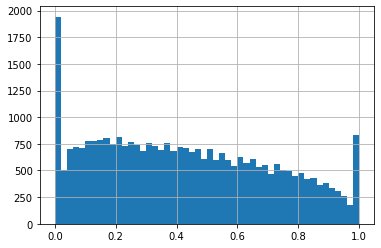

In [13]:
q_diff.hist(bins=50)

Распределение не похоже на какое-то известное, поэтому формулой его аппроксимировать не получится. Возьмём эмпирическое распределение на основе гистограммы.

In [14]:
n_bins = 50
bounds = np.stack([np.linspace(0, 1, n_bins+1)[:-1], np.linspace(0, 1, n_bins+1)[1:]]).T
diff_space = bounds.mean(axis=1).reshape((-1, 1))
diff_probs = np.array([((q_diff >= bound[0]) & (q_diff < bound[1])).sum() for bound in bounds])
diff_probs[-1] += (q_diff == 1).sum()
diff_probs = diff_probs / len(q_diff)
print(f'Sanity check: {diff_probs.sum()}')

Sanity check: 0.9999999999999999


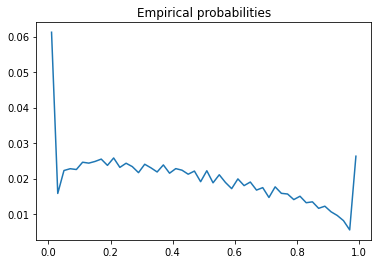

In [15]:
plt.plot(diff_space, diff_probs)
plt.title('Empirical probabilities')
plt.show()

3) Построить модель для $P(X_i|Q=q)$.  
В качестве модели для каждого игрока в отдельности построим логистическую регрессию, единственным признаком которой будет сложность вопроса.
$$
P(X_i | Q=q) = \sigma(wq + w_0).
$$

4) Вычислить интеграл для матожидания (можно численно).  
Для каждого игрока сделаем предсказание для вопросов различной сложности и усредним с весами из *diff_probs*.

In [16]:
df_answers['q_diff'] = q_diff[df_answers['q_idx'].values].values

In [17]:
p_rates = pd.Series(np.zeros(len(player_ids_train), dtype=float),
                      index=player_ids_train)
for idx in tqdm(player_ids_train):
    p_df = df_answers[df_answers['p_idx'] == idx]
    model = LogisticRegression()
    try:
        model.fit(p_df[['q_diff']], p_df['ans'])
        preds = model.predict_proba(diff_space)[:, 1]
        rate = np.dot(preds, diff_probs)
        p_rates[idx] = rate
    except ValueError:
        if not 0 in p_df['ans'].values:
            p_rates[idx] = 1

In [18]:
p_rates.to_csv('data/p_rates.csv')

Посмотрим на распределение получившихся рейтингов:

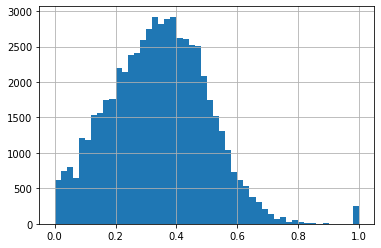

In [19]:
p_rates.hist(bins=50)

In [20]:
p_rates.describe()

count    59224.000000
mean         0.341635
std          0.159843
min          0.000000
25%          0.227475
50%          0.342995
75%          0.450686
max          1.000000
dtype: float64

Во время обучения встречались игроки, которые не ответили ни на один вопрос, либо ответили на все. В таком случае рейтинг равен 0 или 1, так как логистическую регрессию для них обучить невозможно.

Посмотрим на рейтинг игроков, находящихся в первой десятке по официальному рейтингу на сайте рейтинга чгк:

In [21]:
top_idxs = [30152, 30270, 28751, 27822, 27403, 4270, 18332, 18036, 6482, 22799]
for place, idx in enumerate(top_idxs, 1):
    player = players[idx]
    print(f"{place}. {player['name']} {player['patronymic']} {player['surname']}: {p_rates[idx]}")

1. Артём Сергеевич Сорожкин: 0.7462404399269962
2. Сергей Леонидович Спешков: 0.744937665965776
3. Иван Николаевич Семушин: 0.765495003214929
4. Михаил Владимирович Савченков: 0.7482146387565872
5. Максим Михайлович Руссо: 0.7730484738393706
6. Александра Владимировна Брутер: 0.7673787934295416
7. Александр Витальевич Либер: 0.7161458981022918
8. Михаил Ильич Левандовский: 0.7098142333598398
9. Ким Гагикович Галачян: 0.6752295338367517
10. Сергей Игоревич Николенко: 0.6880839776222154


Лучшие 10 игроков по полученному рейтингу (не учитывая игроков с рейтингом 1):

In [22]:
for place, idx in enumerate(p_rates[p_rates != 1].sort_values(ascending=False).index[:10], 1):
    player = players[idx]
    print(f"{place}. {player['name']} {player['patronymic']} {player['surname']}: {p_rates[idx]}")

1. Павел Константинович Щербина: 0.9722234760842277
2. Инга Андрисовна Лоренц: 0.9043330514794683
3. Валентина  Подюкова: 0.9005604150996038
4. Алина Дмитриевна Антипова: 0.8969597057057481
5. София Евгеньевна Лебедева: 0.8938684685127635
6. Михаил Владимирович Завьялов: 0.8912828635918542
7. Давид Сергеевич Кан: 0.8912828635918542
8. Юлия  Крюкова: 0.8842588883611482
9. Наталья  Артемьева: 0.8842588883611482
10. Екатерина  Горелова: 0.8842588883611482


## Task 3

Качество рейтинг-системы оценивается качеством предсказаний результатов турниров. Но сами повопросные результаты наши модели предсказывать вряд ли смогут, ведь неизвестно, насколько сложными окажутся вопросы в будущих турнирах; да и не нужны эти предсказания сами по себе. Поэтому:
 - предложите способ предсказать результаты нового турнира с известными составами, но неизвестными вопросами, в виде ранжирования команд;
 - в качестве метрики качества на тестовом наборе давайте считать ранговые корреляции Спирмена и Кендалла (их можно взять в пакете *scipy*) между реальным ранжированием в результатах турнира и предсказанным моделью, усреднённые по тестовому множеству турниров.

Для определения рейтинга команды воспользуемся вероятностной интерпретацией. Если рейтинг i-го игрока $r_i$ равен вероятности взять им случайный вопрос, тогда вероятность взять вопрос командой $T$ равна
$$
r_T = 1 - \prod_{i \in T} \left(1 - r_i\right).
$$
Данная вероятность относится не к конкретному турниру, а к "среднему" вопросу из выборки, но по ней можно отсортировать команды турнира.  
Для игроков, которых не было в тренировочном наборе, будем использовать просто среднее значение рейтинга.

In [23]:
def evaluate_team(team):
    res = 1
    for player in team:
        if player['player']['id'] in p_rates.index:
            p = p_rates[player['player']['id']]
        else:
            p = p_rates.mean()
        res *= (1 - p)
    return 1 - res

In [24]:
num_tournaments = 0
spearman_coef = 0
kendall_coef = 0
for t_idx in tournaments_test.keys():
    if not results[t_idx]:
        continue
    if not 'position' in results[t_idx][0].keys():
        continue
    ranks_pred = np.zeros(len(results[t_idx]))
    ranks_true = np.zeros(len(results[t_idx]))
    for i, result in enumerate(results[t_idx]):
        ranks_true[i] = result['position']
        ranks_pred[i] = evaluate_team(result['teamMembers'])
    spearman_coef_curr = sps.spearmanr(ranks_pred, -ranks_true)[0]
    kendall_coef_curr = sps.kendalltau(ranks_pred, -ranks_true)[0]
    if not (np.isnan(spearman_coef_curr) or np.isnan(kendall_coef_curr)):
        spearman_coef += spearman_coef_curr
        kendall_coef += kendall_coef_curr
        num_tournaments += 1
print(f'Average Spearman correlation: {spearman_coef/num_tournaments}')
print(f'Average Kendall correlation: {kendall_coef/num_tournaments}')

/home/uladzislaw/anaconda3/envs/dl_py38/lib/python3.8/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/uladzislaw/anaconda3/envs/dl_py38/lib/python3.8/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/uladzislaw/anaconda3/envs/dl_py38/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/uladzislaw/anaconda3/envs/dl_py38/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/uladzislaw/anaconda3/envs/dl_py38/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


Average Spearman correlation: 0.6626302708879771
Average Kendall correlation: 0.5117902844153421


## Task 4

Теперь главное: ЧГК — это всё-таки командная игра. Поэтому:
 - предложите способ учитывать то, что на вопрос отвечают сразу несколько игроков; скорее всего, понадобятся скрытые переменные; не стесняйтесь делать упрощающие предположения, но теперь переменные “игрок X ответил на вопрос Y” при условии данных должны стать зависимыми для игроков одной и той же команды;
 - разработайте EM-схему для обучения этой модели, реализуйте её в коде;
 - обучите несколько итераций, убедитесь, что целевые метрики со временем растут (скорее всего, ненамного, но расти должны), выберите лучшую модель, используя целевые метрики.

Введём скрытую переменную z, обозначающую какие именно игроки взяли вопрос в команде. Если например в команде 6 игроков, и из них вопрос взяли второй и шестой игрок, то для этой комадны для данного вопроса $z = (0, 1, 0, 0, 0, 1)$. Пусть теперь $Q$ - множество всех вопросов, $T_i$ - множество команд, ответивших на $i$-й вопрос, а $M_j$ - множество игроков $j$-й команды, $p_{ki}$ - вероятность того, что $k$-й игрок взял $i$-й вопрос (предсказание модели). Тогда правдоподобие данных при известном z будет выглядеть так:
$$
L(\theta, z) = p(D|\theta, z) = \prod_{i \in Q} \prod_{j \in T_i} \prod_{k \in M_j} p_{ki}(\theta)^{z_{ijk}} (1 - p_{ki}(\theta))^{1 - z_{ijk}}.
$$
Логарифм правдоподобия:
$$
l(\theta, z) = \sum_{i \in Q} \sum_{j \in T_i} \sum_{k \in M_j} z_{ijk} \ln{(p_{ki}(\theta))} + (1 - z_{ijk}) \ln {(1 - p_{ki}(\theta))}.
$$
По свойству линейности матожидания:
$$
E_z[l(\theta, z)] = \sum_{i \in Q} \sum_{j \in T_i} \sum_{k \in M_j} E[z_{ijk}] \ln{(p_{ki}(\theta))} + (1 - E[z_{ijk}]) \ln {(1 - p_{ki}(\theta))}.
$$
В EM-алгоритме на шаге M будем максимизировать найденное матожидание по $\theta$. Для этого обучим логистическую регрессию. В отличие от бейзлайна будем обучать такую модель:
$$
p_{ki} = \sigma(w_k + w_i),
$$
где $w_k$ - коэффициент рейтинга $k$-ого игрока, а $w_i$ - коэффициент сложности $i$-го вопроса (чем меньше, тем вопрос сложнее). Данные коэффициенты можно обучить максимизируя по ним матожидание например с помощью градиентного подъёма.

Теперь определим E-шаг. Если команда не взяла вопрос, то нам наверняка известно что никто из игроков его не взял и $E[z_{ijk}] = 0$. В случае, если команда взяла вопрос, мы не знаем, кто именно из игроков это сделал. Пусть $A_T$ - событие того, что команда правильно ответила на вопрос, $A_i$ - событие того, что $i$-й игрок ответил на вопрос. С помощью модели мы можем предсказать $p_i = P(A_i)$. Тогда
$$
P(A_i|A_T) = \frac{P(A_i, A_T)}{P(A_T)} = \frac{P(A_i)}{P(A_T)} = \frac{P(A_i)}{1 - \prod_{j \in M} (1 - P(A_j))}.
$$
Придерживаясь тех же обозначений, что и для M шага получаем:
$$
E[z_{ijk}] = \frac{p_{ki}}{1 - \prod_{l \in M_j} (1 - p_{li})}
$$

In [25]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(df_answers[['p_idx', 'q_idx']])
X = enc.transform(df_answers[['p_idx', 'q_idx']])

In [26]:
counts = np.array((X != 0).sum(axis=0)).ravel()

In [27]:
w = np.random.randn(X.shape[1])
p = 1 / (1 + np.exp(-X.dot(w)))

In [28]:
df_answers['p_neg'] = 1 - p
dff = df_answers[['t_idx', 'q_idx', 'p_neg']].groupby(by=['t_idx', 'q_idx'], sort=False, as_index=False).prod()
idx_from = (dff['t_idx'].apply(str) + dff['q_idx'].apply(str)).apply(int)
idx_to = (df_answers['t_idx'].apply(str) + df_answers['q_idx'].apply(str)).apply(int)

In [29]:
def e_step(p):
    df_answers['p_neg'] = 1 - p
    prods = df_answers[['t_idx', 'q_idx', 'p_neg']].groupby(by=['t_idx', 'q_idx'], sort=False, as_index=False).prod()['p_neg']
    prods.index = idx_from
    prods = prods[idx_to].to_numpy()
    z = p / (1 - prods)
    z[df_answers['ans'] == 0] = 0
    return z

In [30]:
%%time
z = e_step(p)
print(f'p: {p}')
print(f'z: {z}')

p: [0.88908464 0.19897285 0.79171766 ... 0.79547418 0.47955342 0.79473751]
z: [0.89017358 0.19921655 0.79268735 ... 0.         0.         0.        ]
CPU times: user 3.26 s, sys: 292 ms, total: 3.55 s
Wall time: 3.55 s


Из-за того, что разные игроки играют в разное количество турниров, оптимальный шаг градиентного подъёма для каждого игрока свой (у тех кто больше играют - градиент больше, у других меньше), поэтому я нормирую градиент дополнительно на количество ненулевых элементов соответствующего признака. На практике это ускорило сходимость.

In [31]:
def m_step(X, w, z, n_iters=50, alpha=3):
    w = w.copy()
    for _ in range(n_iters):
        p = 1 / (1 + np.exp(-X.dot(w)))
        grad = (X.T).dot(z * (1 - p) - (1 - z) * p) / counts
        w = w + alpha * grad
    return w

In [32]:
def log_likelihood(z, X, w):
    p = 1 / (1 + np.exp(-X.dot(w)))
    return np.mean(z * np.log(p) + (1 - z) * np.log(1 - p))

In [33]:
%%time
log_likelihood(z, X, w)

CPU times: user 1.45 s, sys: 136 ms, total: 1.59 s
Wall time: 1.59 s


-0.7562908218577705

In [34]:
n_cycles = 50
for i in tqdm(range(n_cycles)):
    if i == 0:
        p = 1 / (1 + np.exp(-X.dot(w)))
        z = e_step(p)
    w = m_step(X, w, z)
    p = 1 / (1 + np.exp(-X.dot(w)))
    z = e_step(p)
    print(f'Log likelihood after cycle {i+1:3}: {log_likelihood(z, X, w)}.')

Log likelihood after cycle   1: -0.3648809316746004.
Log likelihood after cycle   2: -0.3202500676338638.
Log likelihood after cycle   3: -0.30916240483268165.
Log likelihood after cycle   4: -0.3051199744471454.
Log likelihood after cycle   5: -0.3032112823719117.
Log likelihood after cycle   6: -0.3021193640752063.
Log likelihood after cycle   7: -0.30139471175276533.
Log likelihood after cycle   8: -0.30085495182100574.
Log likelihood after cycle   9: -0.30041577219920285.
Log likelihood after cycle  10: -0.3000343516862247.
Log likelihood after cycle  11: -0.29968751106015373.
Log likelihood after cycle  12: -0.29936216963949885.
Log likelihood after cycle  13: -0.299050743996244.
Log likelihood after cycle  14: -0.29874875635945525.
Log likelihood after cycle  15: -0.29845352983332696.
Log likelihood after cycle  16: -0.2981634589403225.
Log likelihood after cycle  17: -0.2978775944356509.
Log likelihood after cycle  18: -0.29759539680093466.
Log likelihood after cycle  19: -0.297

In [35]:
idx_to_position = {}
for i, fname in enumerate(enc.get_feature_names()):
    idx_to_position[int(fname[3:])] = i

In [36]:
p_weights = pd.Series(np.zeros(len(df_answers['p_idx'].unique())),
                      df_answers['p_idx'].unique())
for player in df_answers['p_idx'].unique():
    p_weights[player] = w[idx_to_position[player]]

In [37]:
q_weights = pd.Series(np.zeros(len(df_answers['q_idx'].unique())),
                      df_answers['q_idx'].unique())
for question in df_answers['q_idx'].unique():
    q_weights[question] = w[idx_to_position[question]]

Найдём распределение сложности вопросов

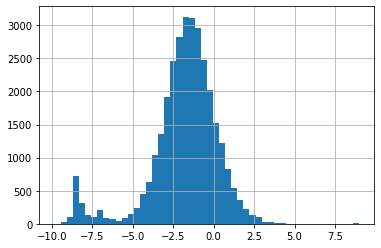

In [38]:
q_weights.hist(bins=50)

Также как и для бейзлайна, для определения рейтинга игрока численно проинтегрируем вероятность игрока ответить на вопрос по распределению сложностей.

In [39]:
n_bins = 50
space = np.linspace(q_weights.min(), q_weights.max(), n_bins+1)
bounds = np.stack([space[:-1], space[1:]]).T
diff_space = bounds.mean(axis=1)
diff_probs = np.array([((q_weights >= bound[0]) & (q_weights < bound[1])).sum() for bound in bounds])
diff_probs = diff_probs / len(q_weights)
print(f'Sanity check: {diff_probs.sum()}')

Sanity check: 0.9999684771301579


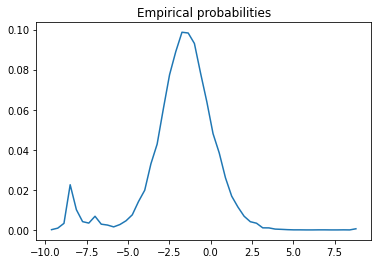

In [40]:
plt.plot(diff_space, diff_probs)
plt.title('Empirical probabilities')
plt.show()

In [41]:
p_rates = pd.Series(np.zeros(len(df_answers['p_idx'].unique()), dtype=float),
                      index=df_answers['p_idx'].unique())
for idx in df_answers['p_idx'].unique():
    preds = 1 / (1 + np.exp(-(p_weights[idx] + diff_space)))
    rate = np.dot(preds, diff_probs)
    p_rates[idx] = rate

In [42]:
p_rates.to_csv('data/p_rates_em.csv')

Распределение рейтингов

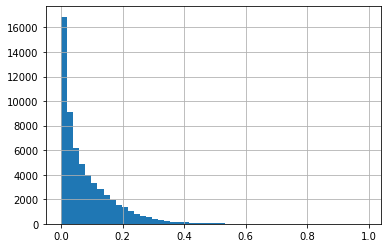

In [43]:
p_rates.hist(bins=50)

Посмотрим на рейтинг игроков, находящихся в первой десятке по официальному рейтингу на сайте рейтинга чгк:

In [44]:
top_idxs = [30152, 30270, 28751, 27822, 27403, 4270, 18332, 18036, 6482, 22799]
for place, idx in enumerate(top_idxs, 1):
    player = players[idx]
    print(f"{place}. {player['name']} {player['patronymic']} {player['surname']}: {p_rates[idx]}")

1. Артём Сергеевич Сорожкин: 0.540429635920944
2. Сергей Леонидович Спешков: 0.37565992644990165
3. Иван Николаевич Семушин: 0.6209956791343053
4. Михаил Владимирович Савченков: 0.3005981606515755
5. Максим Михайлович Руссо: 0.36332658523050715
6. Александра Владимировна Брутер: 0.07670408705023506
7. Александр Витальевич Либер: 0.3289321052436378
8. Михаил Ильич Левандовский: 0.40373870031202297
9. Ким Гагикович Галачян: 0.3127302244991639
10. Сергей Игоревич Николенко: 0.39350318103029314


In [45]:
num_tournaments = 0
spearman_coef = 0
kendall_coef = 0
for t_idx in tournaments_test.keys():
    if not results[t_idx]:
        continue
    if not 'position' in results[t_idx][0].keys():
        continue
    ranks_pred = np.zeros(len(results[t_idx]))
    ranks_true = np.zeros(len(results[t_idx]))
    for i, result in enumerate(results[t_idx]):
        ranks_true[i] = result['position']
        ranks_pred[i] = evaluate_team(result['teamMembers'])
    spearman_coef_curr = sps.spearmanr(ranks_pred, -ranks_true)[0]
    kendall_coef_curr = sps.kendalltau(ranks_pred, -ranks_true)[0]
    if not (np.isnan(spearman_coef_curr) or np.isnan(kendall_coef_curr)):
        spearman_coef += spearman_coef_curr
        kendall_coef += kendall_coef_curr
        num_tournaments += 1
print(f'Average Spearman correlation: {spearman_coef/num_tournaments}')
print(f'Average Kendall correlation: {kendall_coef/num_tournaments}')

/home/uladzislaw/anaconda3/envs/dl_py38/lib/python3.8/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/uladzislaw/anaconda3/envs/dl_py38/lib/python3.8/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/uladzislaw/anaconda3/envs/dl_py38/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/uladzislaw/anaconda3/envs/dl_py38/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/uladzislaw/anaconda3/envs/dl_py38/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


Average Spearman correlation: 0.7593582892587583
Average Kendall correlation: 0.6035367804930335


# Task 5

А что там с вопросами? Постройте “рейтинг-лист” турниров по сложности вопросов. Соответствует ли он интуиции (например, на чемпионате мира в целом должны быть сложные вопросы, а на турнирах для школьников — простые)? Если будет интересно: постройте топ сложных и простых вопросов со ссылками на конкретные записи в базе вопросов ЧГК (это чисто техническое дело, тут никакого ML нету).

In [46]:
tournament_diffs = {}
for tournament in tournaments_train.keys():
    tournament_diff = 0
    n_questions = 0
    if len(results[tournament]) == 0:
        continue
    if not 'mask' in results[tournament][0].keys():
        continue
    for i in range(len(results[tournament][0]['mask'] or [])):
        q_idx = tournament*10000 + i
        try:
            tournament_diff -= w[idx_to_position[q_idx]]
            n_questions += 1
        except KeyError:
            pass
    if n_questions > 0:
        tournament_diffs[tournament] = tournament_diff / n_questions

In [47]:
tournament_diffs = pd.Series(tournament_diffs).sort_values(ascending=False)

In [48]:
print('Самые сложные турниры:')
for i, tournament in enumerate(tournament_diffs.index[:10], 1):
    print(f'{i:2}. {tournaments[tournament]["name"]}')

Самые сложные турниры:
 1. Чемпионат Санкт-Петербурга. Первая лига
 2. (А) Славянка без раздаток. 4 этап
 3. Угрюмый Ёрш
 4. Зеркало мемориала памяти Михаила Басса
 5. Воображаемый музей
 6. Седьмая октава: Кубок Равноденствия. Лига Наций: Прибалтика
 7. Чемпионат Таджикистана
 8. Чемпионат Мира. Этап 2 Группа С
 9. Первенство правого полушария
10. Чемпионат Мира. Этап 2. Группа В


In [49]:
print('Самые простые турниры:')
for i, tournament in enumerate(tournament_diffs.index[-1:-11:-1], 1):
    print(f'{i:2}. {tournaments[tournament]["name"]}')

Самые простые турниры:
 1. Синхрон Лиги Разума
 2. Школьная лига. III тур.
 3. (а)Синхрон-lite. Лига старта. Эпизод V
 4. Школьная лига. I тур.
 5. Школьный Синхрон-lite. Выпуск 2.5
 6. One ring - async
 7. Школьная лига
 8. Межфакультетский кубок МГУ. Отбор №4
 9. Школьная лига. II тур.
10. (а)Синхрон-lite. Лига старта. Эпизод VII


Результаты действительно соответствуют интуиции.

# Task 6

In [50]:
def make_top_table(min_questions, length=20):
    df_res = {
        'place': [],
        'name': [],
        'patronymic': [],
        'surname': [],
        'rate': [],
        'questions': [],
    }
    global p_rates
    p_rates = p_rates.sort_values(ascending=False)
    for p_idx in p_rates.index:
        questions = (df_answers['p_idx'] == p_idx).sum()
        if questions >= min_questions:
            df_res['place'].append(len(df_res['place']) + 1)
            df_res['name'].append(players[p_idx]['name'])
            df_res['patronymic'].append(players[p_idx]['patronymic'])
            df_res['surname'].append(players[p_idx]['surname'])
            df_res['rate'].append(p_rates[p_idx])
            df_res['questions'].append(questions)
            if len(df_res['place']) == length:
                break
    df_res = pd.DataFrame(df_res)
    df_res.index = df_res['place']
    df_res = df_res.drop(['place'], axis=1)
    return df_res

In [51]:
make_top_table(min_questions=0)

,name,patronymic,surname,rate,questions
place,,,,,
1,Юрий,Леонидович,Фёдоров,0.988152,6
2,Вячеслав,Игоревич,Филитов,0.980972,1
3,Роман,Валерьевич,Тронин,0.978967,1
4,Рита,,Полонская,0.978667,1
5,Анна,Ивановна,Пятибратова,0.978342,5
6,Юлия,Александровна,Чернышёва,0.977314,2
7,София,,Хоперия,0.976260,1
8,Владимир,,Карукес,0.974327,1
9,Илья,Сергеевич,Кижватов,0.973694,2


Как видно, в топ попали игроки, у которых очень мало сыграных вопросов. Попробуем брать в топ исключительно тех игроков, у кого сыграно более 1000 вопросов.

In [52]:
make_top_table(min_questions=1000)

,name,patronymic,surname,rate,questions
place,,,,,
1,Иван,Николаевич,Семушин,0.620996,3718
2,Игорь,Викторович,Мокин,0.593373,1220
3,Артём,Сергеевич,Сорожкин,0.540430,4708
4,Александр,Валерьевич,Марков,0.536170,2877
5,Александр,Геннадьевич,Коробейников,0.534395,1392
6,Александр,Ефимович,Мартынов,0.521074,1467
7,Антон,Андреевич,Мартыненко,0.518884,2403
8,Станислав,Григорьевич,Мереминский,0.515665,1616
9,Мария,Владимировна,Кленницкая,0.513727,1047


Теперь в топ попали действительно хорошие игроки, находящиеся в топе на сайте рейтинга. Но для составления рейтинг-системы было бы несправедливо просто выкинуть тех игроков, кто сыграл мало турниров, но сыграл их хорошо, ведь их тоже нужно как-то сравнивать между собой. Попробуем сделать что-то вроде байесовского сглаживания. Из результатов рейтинга без сглаживания видно, что у большинства игроков вероятность взять случайный вопрос из базы достаточно мала, поэтому ожидается что новые игроки поначалу будут играть плохо. Добавим каждому игроку одинаковое количество неправильно отвеченных вопросов в таблицу (например 150, что соответствует трём турнирам - это число можно подбирать на валидации). Тогда рейтинг всех игроков понизится, но в особенности к этому будет чувствителен рейтинг игроков, сыгравших мало игр.

In [53]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(df_answers[['p_idx', 'q_idx']])
X = enc.transform(df_answers[['p_idx', 'q_idx']])
main_block_len = X.shape[0]

In [54]:
p_for_smoothing = np.repeat(df_answers['p_idx'].unique(), 150)
q_for_smoothing = np.zeros(len(p_for_smoothing))
X_smooth = enc.transform(np.stack([p_for_smoothing, q_for_smoothing]).T)

In [55]:
X_full = vstack([X, X_smooth])

In [56]:
counts = np.array((X_full != 0).sum(axis=0)).ravel()

In [57]:
w = np.random.randn(X.shape[1])
p = 1 / (1 + np.exp(-X.dot(w)))

In [58]:
%%time
z = np.concatenate([e_step(p), np.zeros(len(p_for_smoothing))])
print(f'p: {p}')
print(f'z: {z}')

p: [0.13614722 0.47746089 0.84968222 ... 0.16718233 0.46375985 0.12593409]
z: [0.13681546 0.47980437 0.85385264 ... 0.         0.         0.        ]
CPU times: user 3.02 s, sys: 304 ms, total: 3.33 s
Wall time: 3.33 s


In [59]:
%%time
log_likelihood(z, X_full, w)

CPU times: user 1.92 s, sys: 172 ms, total: 2.1 s
Wall time: 2.1 s


-0.7738803862470797

In [60]:
n_cycles = 50
for i in tqdm(range(n_cycles)):
    if i == 0:
        p = 1 / (1 + np.exp(-X.dot(w)))
        z = np.concatenate([e_step(p), np.zeros(len(p_for_smoothing))])
    w = m_step(X_full, w, z)
    p = 1 / (1 + np.exp(-X.dot(w)))
    z = np.concatenate([e_step(p), np.zeros(len(p_for_smoothing))])
    print(f'Log likelihood after cycle {i+1:3}: {log_likelihood(z, X_full, w)}.')

Log likelihood after cycle   1: -0.2601408968525136.
Log likelihood after cycle   2: -0.22472964155186542.
Log likelihood after cycle   3: -0.2159013904510832.
Log likelihood after cycle   4: -0.21255061302629052.
Log likelihood after cycle   5: -0.21090934167137926.
Log likelihood after cycle   6: -0.2099473225095414.
Log likelihood after cycle   7: -0.20930229622958785.
Log likelihood after cycle   8: -0.2088233802863833.
Log likelihood after cycle   9: -0.20843929194747268.
Log likelihood after cycle  10: -0.20811300859989262.
Log likelihood after cycle  11: -0.20782388945106478.
Log likelihood after cycle  12: -0.20755979463607316.
Log likelihood after cycle  13: -0.20731328225953163.
Log likelihood after cycle  14: -0.20707963637995008.
Log likelihood after cycle  15: -0.20685578587940248.
Log likelihood after cycle  16: -0.20663968582075085.
Log likelihood after cycle  17: -0.20642995051092666.
Log likelihood after cycle  18: -0.20622562759447322.
Log likelihood after cycle  19: 

In [61]:
idx_to_position = {}
for i, fname in enumerate(enc.get_feature_names()):
    idx_to_position[int(fname[3:])] = i
p_weights = pd.Series(np.zeros(len(df_answers['p_idx'].unique())),
                      df_answers['p_idx'].unique())
for player in df_answers['p_idx'].unique():
    p_weights[player] = w[idx_to_position[player]]
q_weights = pd.Series(np.zeros(len(df_answers['q_idx'].unique())),
                      df_answers['q_idx'].unique())
for question in df_answers['q_idx'].unique():
    q_weights[question] = w[idx_to_position[question]]

Распределение сложности вопросов

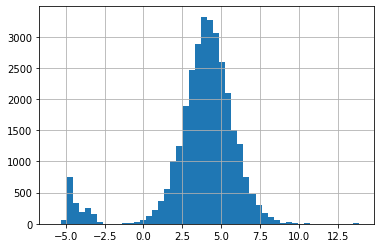

In [62]:
q_weights.hist(bins=50)

In [63]:
n_bins = 50
space = np.linspace(q_weights.min(), q_weights.max(), n_bins+1)
bounds = np.stack([space[:-1], space[1:]]).T
diff_space = bounds.mean(axis=1)
diff_probs = np.array([((q_weights >= bound[0]) & (q_weights < bound[1])).sum() for bound in bounds])
diff_probs = diff_probs / len(q_weights)
print(f'Sanity check: {diff_probs.sum()}')

Sanity check: 0.9999684771301579


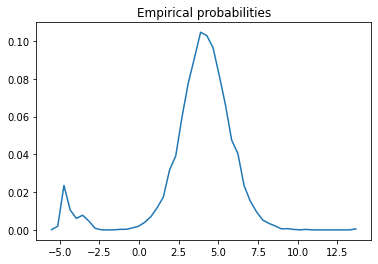

In [64]:
plt.plot(diff_space, diff_probs)
plt.title('Empirical probabilities')
plt.show()

In [65]:
p_rates = pd.Series(np.zeros(len(df_answers['p_idx'].unique()), dtype=float),
                      index=df_answers['p_idx'].unique())
for idx in df_answers['p_idx'].unique():
    preds = 1 / (1 + np.exp(-(p_weights[idx] + diff_space)))
    rate = np.dot(preds, diff_probs)
    p_rates[idx] = rate

In [66]:
p_rates.to_csv('data/p_rates_em_smoothed.csv')

Распределение рейтингов

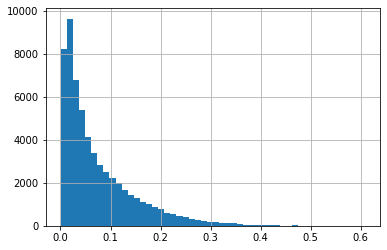

In [67]:
p_rates.hist(bins=50)

In [68]:
top_idxs = [30152, 30270, 28751, 27822, 27403, 4270, 18332, 18036, 6482, 22799]
for place, idx in enumerate(top_idxs, 1):
    player = players[idx]
    print(f"{place}. {player['name']} {player['patronymic']} {player['surname']}: {p_rates[idx]}")

1. Артём Сергеевич Сорожкин: 0.5456930867189971
2. Сергей Леонидович Спешков: 0.2296784832850888
3. Иван Николаевич Семушин: 0.6070658053148512
4. Михаил Владимирович Савченков: 0.28046169205070604
5. Максим Михайлович Руссо: 0.34214792469092054
6. Александра Владимировна Брутер: 0.3184178358039256
7. Александр Витальевич Либер: 0.5185220967317213
8. Михаил Ильич Левандовский: 0.3119106622168761
9. Ким Гагикович Галачян: 0.32802058796000727
10. Сергей Игоревич Николенко: 0.3502904739240475


In [69]:
num_tournaments = 0
spearman_coef = 0
kendall_coef = 0
for t_idx in tournaments_test.keys():
    if not results[t_idx]:
        continue
    if not 'position' in results[t_idx][0].keys():
        continue
    ranks_pred = np.zeros(len(results[t_idx]))
    ranks_true = np.zeros(len(results[t_idx]))
    for i, result in enumerate(results[t_idx]):
        ranks_true[i] = result['position']
        ranks_pred[i] = evaluate_team(result['teamMembers'])
    spearman_coef_curr = sps.spearmanr(ranks_pred, -ranks_true)[0]
    kendall_coef_curr = sps.kendalltau(ranks_pred, -ranks_true)[0]
    if not (np.isnan(spearman_coef_curr) or np.isnan(kendall_coef_curr)):
        spearman_coef += spearman_coef_curr
        kendall_coef += kendall_coef_curr
        num_tournaments += 1
print(f'Average Spearman correlation: {spearman_coef/num_tournaments}')
print(f'Average Kendall correlation: {kendall_coef/num_tournaments}')

/home/uladzislaw/anaconda3/envs/dl_py38/lib/python3.8/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/uladzislaw/anaconda3/envs/dl_py38/lib/python3.8/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/uladzislaw/anaconda3/envs/dl_py38/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/uladzislaw/anaconda3/envs/dl_py38/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/uladzislaw/anaconda3/envs/dl_py38/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


Average Spearman correlation: 0.7748671548973513
Average Kendall correlation: 0.618606620032114


In [70]:
make_top_table(min_questions=0)

,name,patronymic,surname,rate,questions
place,,,,,
1,Илья,Сергеевич,Немец,0.608777,75
2,Иван,Николаевич,Семушин,0.607066,3718
3,Игорь,Викторович,Мокин,0.579707,1220
4,Евгений,Павлович,Спектор,0.555909,244
5,Александр,Геннадьевич,Коробейников,0.547804,1392
6,Артём,Сергеевич,Сорожкин,0.545693,4708
7,Светлана,Анатольевна,Гусарова,0.531072,111
8,Александр,Валерьевич,Марков,0.530837,2877
9,Алексей,Владимирович,Гилёв,0.529963,4334


Как видно, в топ сглаженной модели попали уже игроки с большим количеством вопросов.

# Task 7 (рассуждения, без реализации)

Действительно, обучать модель только за последний год - это достаточно грубый способ учёта изменения навыков. Нужен какой-то компромиссный метод между учётом всего опыта равносильно и только последнего года. Чтобы учесть предыдущий опыт игрока, я бы предложил обучить модель, аналогичную предложенной в 4 задаче для каждого года в отдельности. После этого можно взять среднее между полученными значениями рейтинга, но с определёнными весами, где у более давних годов будет меньше вес, чем у последних. Веса можно подобрать либо вручную, в зависимости от того, насколько быстро мы хотим, чтобы модель забывала предыдущий опыт, либо взять последний год в качестве валидационных данных и на нём подобрать оптимальные веса, которые максимизировали бы целевую метрику.